In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from razdel import tokenize
import warnings
warnings.filterwarnings('ignore')

In [2]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, word2idx, max_length):
        self.texts = texts
        self.labels = labels
        self.word2idx = word2idx
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Токенизация с помощью razdel
        tokens = [token.text for token in tokenize(text)][:self.max_length]
        sequence = [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]

        # Паддинг
        if len(sequence) < self.max_length:
            sequence += [self.word2idx['<PAD>']] * (self.max_length - len(sequence))
        else:
            sequence = sequence[:self.max_length]

        return torch.tensor(sequence), torch.tensor(label)

def preprocess_text(text):
    # Проверяем что текст не None и строка
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    # Удаляю все символы кроме букв и пробелов
    text = re.sub(r'[^a-zA-Zа-яА-Я\s]', '', text)
    # Удаляю лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def load_and_preprocess_data(file_path, sample_size=60000):
    df = pd.read_csv(file_path, encoding='utf-8', sep=',')
    
    # Удаляем лишние колонки если есть
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    
    print(f"Размер данных: {df.shape}")
    print(f"Колонки: {df.columns.tolist()}")
    print(f"\nПримеры данных:")
    print(df[['public_petition_text', 'reason_category']].sample(3))
    
    if len(df) > sample_size:
        df = df.sample(sample_size, random_state=42)
        print(f"Взята выборка: {len(df)} строк")
    
    # Проверяем наличие NaN значений
    print(f"\nПроверка данных:")
    print(f"Пустые тексты: {df['public_petition_text'].isna().sum()}")
    print(f"Пустые категории: {df['reason_category'].isna().sum()}")
    
    # Удаляем пустые значения
    df = df.dropna(subset=['public_petition_text', 'reason_category'])
    print(f"Данные после очистки: {len(df)} строк")
    
    df['text_clean'] = df['public_petition_text'].apply(preprocess_text)
    
    print(f"\nАнализ категорий:")
    category_counts = df['reason_category'].value_counts()
    print(category_counts)
    print(f"Всего категорий: {len(category_counts)}")
    
    return df

In [3]:
def balance_dataset(df, undersample_threshold=900, oversample_threshold=400, target_size=600):
    category_counts = df['reason_category'].value_counts()
    print("Исходное распределение:")
    
    balanced_dfs = []
    
    for category in df['reason_category'].unique():
        category_df = df[df['reason_category'] == category]
        original_count = len(category_df)
        
        if original_count >= undersample_threshold:
            # Большие классы - undersampling
            balanced_category = category_df.sample(undersample_threshold, random_state=42)
            print(f"   {category}: {original_count} → {undersample_threshold} (undersampled)")
            
        elif original_count >= oversample_threshold:
            # Средние классы - оставляем как есть
            balanced_category = category_df
            print(f"   {category}: {original_count} (оставлен)")
            
        else:
            # Маленькие классы - oversampling до target_size = 600
            if original_count > 0:
                balanced_category = category_df.sample(target_size, replace=True, random_state=42)
                print(f"   {category}: {original_count} → {target_size} (oversampled)")
            else:
                balanced_category = category_df
                print(f"   {category}: {original_count} (очень маленький, оставлен)")
        
        balanced_dfs.append(balanced_category)
    
    balanced_df = pd.concat(balanced_dfs, ignore_index=True)
    
    print(f"\nИтоговое распределение:")
    final_counts = balanced_df['reason_category'].value_counts()
    for category, count in final_counts.items():
        print(f"   {category}: {count} примеров")
    
    print(f"Всего примеров: {len(balanced_df)}")
    print(f"Сохранено категорий: {len(final_counts)}")
    
    return balanced_df

def build_vocabulary(texts, min_freq=2):
    """Создает словарь для векторизации токенов"""
    
    # Собираем все слова с помощью razdel
    all_words = []
    for text in texts:
        # Токенизируем каждый текст с помощью razdel
        tokens = [token.text for token in tokenize(text)]
        all_words.extend(tokens)
    
    # Считаем частоты
    word_freq = Counter(all_words)
    
    # Создаем словарь
    vocabulary = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    
    for word, freq in word_freq.items():
        if freq >= min_freq:
            vocabulary[word] = idx
            idx += 1
    
    print(f"\nВсего уникальных слов: {len(word_freq)}")
    print(f"Слов в словаре: {len(vocabulary)}")
    
    return vocabulary

def prepare_data(df):
    # Создаем словарь
    vocab = build_vocabulary(df['text_clean'].tolist(), min_freq=2)
    
    # Кодируем целевой признак
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(df['reason_category'])
    
    for i, class_name in enumerate(label_encoder.classes_):
        class_count = (labels_encoded == i).sum()
        print(f"   '{class_name}' -> {i} ({class_count} примеров)")
    
    # Разделяем данные
    X_train, X_test, y_train, y_test = train_test_split(
        df['text_clean'].tolist(),
        labels_encoded.tolist(),
        test_size=0.2,
        random_state=42,
        stratify=labels_encoded
    )
    
    print(f"\nОбучающая выборка: {len(X_train)} текстов")
    print(f"Тестовая выборка: {len(X_test)} текстов")
    
    return X_train, X_test, y_train, y_test, vocab, label_encoder

In [4]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        
    def forward(self, hidden_states, final_hidden):
        """
        hidden_states: [batch_size, seq_len, hidden_dim]
        final_hidden: [batch_size, hidden_dim] - последнее скрытое состояние
        """
        batch_size, seq_len, hidden_dim = hidden_states.shape
        
        # Вычисляем e_i = h_i^T * h_n (скалярное произведение)
        # Расширяем final_hidden для batch и seq_len
        final_hidden_expanded = final_hidden.unsqueeze(1)  # [batch_size, 1, hidden_dim]
        
        # Вычисляем скалярное произведение для каждого временного шага
        e = torch.bmm(hidden_states, final_hidden_expanded.transpose(1, 2))  # [batch_size, seq_len, 1]
        e = e.squeeze(-1)  # [batch_size, seq_len]
        
        # Применяем softmax для получения весов внимания
        alpha = nn.functional.softmax(e, dim=1)  # [batch_size, seq_len]
        
        # Вычисляем взвешенную сумму скрытых состояний
        alpha_expanded = alpha.unsqueeze(2)  # [batch_size, seq_len, 1]
        weighted_sum = torch.sum(alpha_expanded * hidden_states, dim=1)  # [batch_size, hidden_dim]
        
        # Конкатенируем последнее скрытое состояние и взвешенную сумму
        c = torch.cat((final_hidden, weighted_sum), dim=1)  # [batch_size, hidden_dim * 2]
        
        return c

In [5]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super(RNNClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers,
                         batch_first=True, bidirectional=False, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        # Берем последнее скрытое состояние
        hidden = self.dropout(hidden[-1])
        return self.fc(hidden)

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                           batch_first=True, bidirectional=False, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        return self.fc(hidden)

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super(GRUClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers,
                         batch_first=True, bidirectional=False, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)
        hidden = self.dropout(hidden[-1])
        return self.fc(hidden)

In [6]:
class RNNWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super(RNNWithAttention, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers,
                         batch_first=True, bidirectional=False, dropout=dropout)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        last_hidden = hidden[-1]
        context = self.attention(output, last_hidden)
        context = self.dropout(context)
        return self.fc(context)

class LSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super(LSTMWithAttention, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                           batch_first=True, bidirectional=False, dropout=dropout)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        last_hidden = hidden[-1]
        context = self.attention(output, last_hidden)
        context = self.dropout(context)
        return self.fc(context)

class GRUWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super(GRUWithAttention, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers,
                         batch_first=True, bidirectional=False, dropout=dropout)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)
        last_hidden = hidden[-1]
        context = self.attention(output, last_hidden)
        context = self.dropout(context)
        return self.fc(context)

In [7]:
# Функция для обучения модели
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10, model_name="Model"):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        # Тренировка
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Валидация
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    
        if (epoch + 1) % 5 == 0:
            print(f'{model_name} - Epoch {epoch+1}/{epochs}:')
            print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    
    return train_losses, val_losses, val_accuracies

# Функция для оценки модели
def evaluate_model(model, test_loader, device, label_encoder, model_name="Model"):
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            probs = torch.softmax(output, dim=1)
            _, predicted = torch.max(output.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='weighted')
    
    print(f"\n{model_name} Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    
    return accuracy, f1, all_preds, all_targets, all_probs

# Сравнение моделей
def compare_models(results, label_encoder):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    colors = {'RNN': 'blue', 'RNN+Attention': 'lightblue',
              'LSTM': 'green', 'LSTM+Attention': 'lightgreen',
              'GRU': 'red', 'GRU+Attention': 'pink'}
    
    # Графики точности
    for model_name, metrics in results.items():
        if 'Attention' in model_name:
            linestyle = '--'
        else:
            linestyle = '-'
        
        axes[0, 0].plot(metrics['val_accuracies'], label=model_name, 
                       color=colors.get(model_name, 'gray'), linestyle=linestyle)
        axes[0, 1].plot(metrics['train_losses'], label=model_name,
                       color=colors.get(model_name, 'gray'), linestyle=linestyle)
    
    axes[0, 0].set_title('Validation Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    axes[0, 1].set_title('Training Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Сравнение метрик
    model_names = list(results.keys())
    accuracies = [results[model]['test_accuracy'] for model in model_names]
    f1_scores = [results[model]['test_f1'] for model in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    axes[1, 0].bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
    axes[1, 0].bar(x + width/2, f1_scores, width, label='F1 Score', color='lightcoral')
    axes[1, 0].set_xlabel('Model')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_title('Test Metrics Comparison')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(model_names, rotation=45)
    axes[1, 0].legend()
    axes[1, 0].grid(True, axis='y')
    
    # Улучшение с вниманием
    improvements = []
    labels = []
    for base_model in ['RNN', 'LSTM', 'GRU']:
        base_key = base_model
        attn_key = f'{base_model}+Attention'
        
        if base_key in results and attn_key in results:
            base_acc = results[base_key]['test_accuracy']
            attn_acc = results[attn_key]['test_accuracy']
            improvement = ((attn_acc - base_acc) / base_acc) * 100
            improvements.append(improvement)
            labels.append(base_model)
    
    if improvements:
        axes[1, 1].bar(labels, improvements, color=['blue', 'green', 'red'])
        axes[1, 1].set_xlabel('Model')
        axes[1, 1].set_ylabel('Improvement (%)')
        axes[1, 1].set_title('Accuracy Improvement with Attention')
        axes[1, 1].grid(True, axis='y')
        
        # Добавляем значения на столбцы
        for i, v in enumerate(improvements):
            axes[1, 1].text(i, v + 0.5 if v >= 0 else v - 1.5, f'{v:.2f}%', 
                          ha='center', va='bottom' if v >= 0 else 'top')
    
    plt.tight_layout()
    plt.show()
    
    print()
    print("Сводная таблица")
    print()
    print(f"{'Model':<20} {'Accuracy':<12} {'F1 Score':<12} {'Improvement':<12}")
    print("-"*80)
    
    for model_name in ['RNN', 'RNN+Attention', 'LSTM', 'LSTM+Attention', 'GRU', 'GRU+Attention']:
        if model_name in results:
            metrics = results[model_name]
            print(f"{model_name:<20} {metrics['test_accuracy']:.4f}      {metrics['test_f1']:.4f}      ", end="")
            
            # Вычисляем улучшение
            if 'Attention' in model_name:
                base_model = model_name.replace('+Attention', '')
                if base_model in results:
                    improvement = ((metrics['test_accuracy'] - results[base_model]['test_accuracy']) / 
                                  results[base_model]['test_accuracy']) * 100
                    print(f"+{improvement:.2f}%")
                else:
                    print("-")
            else:
                print("-")
    
    print("-"*80)
    
    # Находим лучшую модель
    best_model_name = max(results.items(), key=lambda x: x[1]['test_accuracy'])[0]
    best_accuracy = results[best_model_name]['test_accuracy']
    print(f"\nДучшая модель: {best_model_name} (Accuracy: {best_accuracy:.4f})")
    
    return best_model_name


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


file_path = 'C:/Users/Zver/Desktop/machine_learning/data/Petitions.csv'
df = load_and_preprocess_data(file_path, sample_size=60000)

print("\n" + "-"*50)
print("Подготовка данных")

df_balanced = balance_dataset(df, undersample_threshold=800, oversample_threshold=400, target_size=600)

X_train, X_test, y_train, y_test, vocab, label_encoder = prepare_data(df_balanced)
print("-"*50)

# Параметры
BATCH_SIZE = 128
MAX_LENGTH = 50
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 256
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_encoder.classes_)
EPOCHS = 20
LEARNING_RATE = 0.001

print(f"\nModel Parameters:")
print(f"VOCAB_SIZE: {VOCAB_SIZE}")
print(f"EMBEDDING_DIM: {EMBEDDING_DIM}")
print(f"HIDDEN_DIM: {HIDDEN_DIM}")
print(f"OUTPUT_DIM: {OUTPUT_DIM}")
print(f"MAX_LENGTH: {MAX_LENGTH}")
print(f"BATCH_SIZE: {BATCH_SIZE}")

# Создаем DataLoaders
train_dataset = TextDataset(X_train, y_train, vocab, MAX_LENGTH)
test_dataset = TextDataset(X_test, y_test, vocab, MAX_LENGTH)

# Разделяем train на train и validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoader sizes:")
print(f"Train: {len(train_loader.dataset)} samples")
print(f"Validation: {len(val_loader.dataset)} samples")
print(f"Test: {len(test_loader.dataset)} samples")

# Создаем словарь
results = {}

# Модели
models = {
    'RNN': RNNClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM),
    'RNN+Attention': RNNWithAttention(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM),
    'LSTM': LSTMClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM),
    'LSTM+Attention': LSTMWithAttention(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM),
    'GRU': GRUClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM),
    'GRU+Attention': GRUWithAttention(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
}

# Обучаем и оцениваем каждую модель
for model_name, model in models.items():
    print("\n" + "-"*50)
    print(f"Обучение {model_name}")
    print("-"*50)
    
    # Перемещаем модель на устройство
    model = model.to(device)
    
    # Функция потерь и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Обучение
    train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, 
        epochs=EPOCHS, model_name=model_name
    )

            # Оценка
    test_accuracy, test_f1, predictions, targets, probs = evaluate_model(
        model, test_loader, device, label_encoder, model_name=model_name
    )
    
    # Сохраняем результаты
    results[model_name] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy,
        'test_f1': test_f1,
        'predictions': predictions,
        'targets': targets,
        'probs': probs
    }




Размер данных: (59889, 2)
Колонки: ['public_petition_text', 'reason_category']

Примеры данных:
                                    public_petition_text  reason_category
50367                не работает пассажирский лифт пар.2   Содержание МКД
14531                               Выбоины на тротуаре.  Благоустройство
23569  Несанкционированные объявления борделей на опо...  Благоустройство

Проверка данных:
Пустые тексты: 0
Пустые категории: 0
Данные после очистки: 59889 строк

Анализ категорий:
reason_category
Благоустройство                                                                     34769
Содержание МКД                                                                      14461
Нарушение правил пользования общим имуществом                                        2170
Незаконная информационная и (или) рекламная конструкция                              1831
Фасад                                                                                1483
Повреждения или неисправность элем

Сравнение результатов


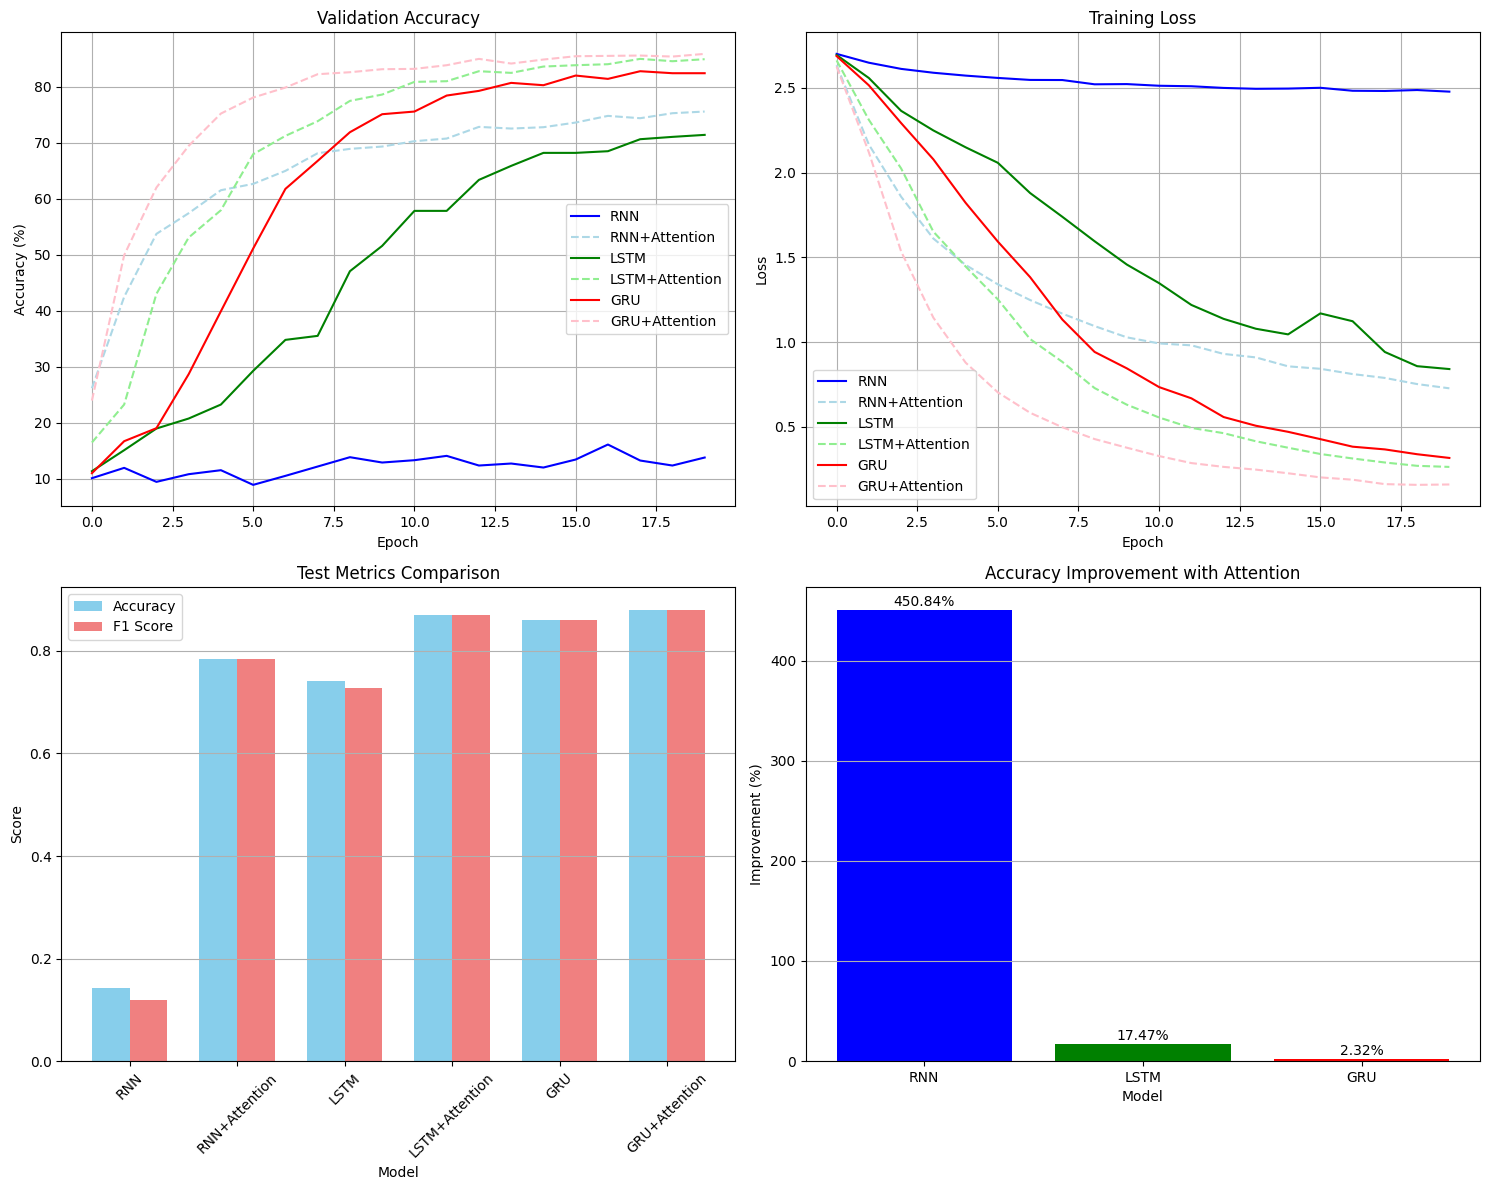


Сводная таблица

Model                Accuracy     F1 Score     Improvement 
--------------------------------------------------------------------------------
RNN                  0.1422      0.1184      -
RNN+Attention        0.7835      0.7834      +450.84%
LSTM                 0.7407      0.7275      -
LSTM+Attention       0.8701      0.8700      +17.47%
GRU                  0.8606      0.8594      -
GRU+Attention        0.8806      0.8791      +2.32%
--------------------------------------------------------------------------------

Дучшая модель: GRU+Attention (Accuracy: 0.8806)


In [11]:
print("Сравнение результатов")
best_model = compare_models(results, label_encoder)


Анализ для лучшей модели: GRU+Attention


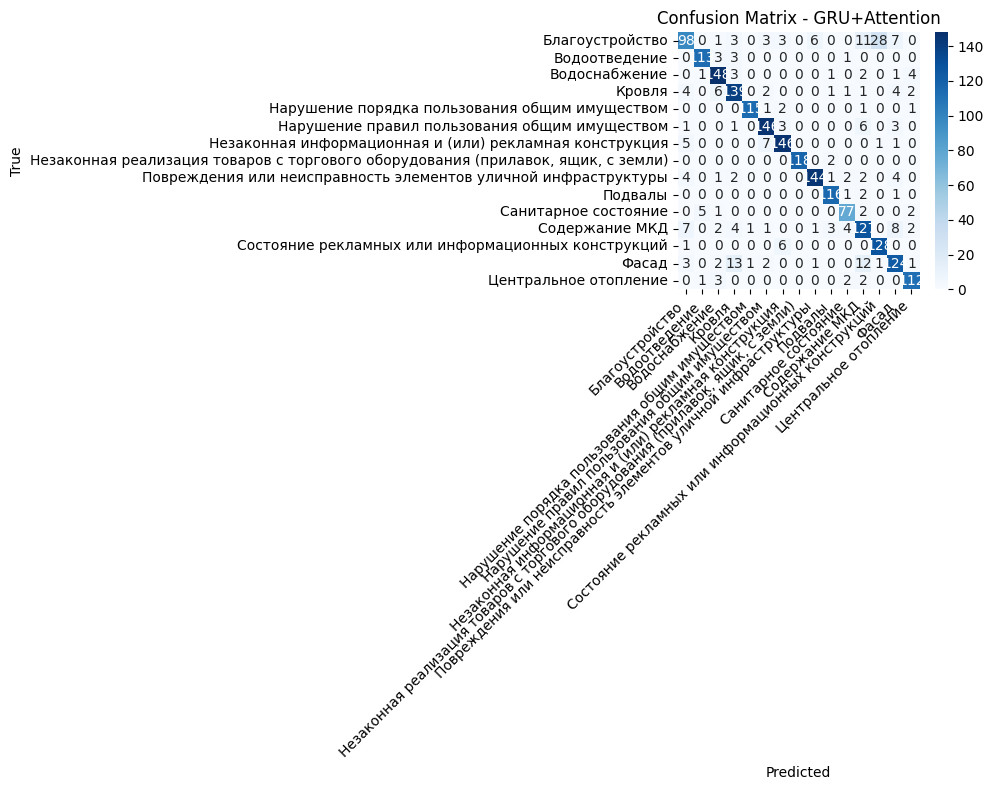


Classification Report:
                                                                                  precision    recall  f1-score   support

                                                                 Благоустройство       0.80      0.61      0.69       160
                                                                   Водоотведение       0.94      0.94      0.94       120
                                                                   Водоснабжение       0.89      0.93      0.91       160
                                                                          Кровля       0.83      0.87      0.85       160
                                  Нарушение порядка пользования общим имуществом       0.98      0.96      0.97       120
                                   Нарушение правил пользования общим имуществом       0.90      0.91      0.91       160
                         Незаконная информационная и (или) рекламная конструкция       0.91      0.91      0.91       160

In [12]:
print(f"Анализ для лучшей модели: {best_model}")

best_results = results[best_model]

# Confusion Matrix
cm = confusion_matrix(best_results['targets'], best_results['predictions'])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(best_results['targets'], best_results['predictions'], 
                            target_names=label_encoder.classes_))

